Depth of Cover Compound Likelihood Demo
=======================================

This is a simulated regression task to test a generalised linear model (GLM) for predicting the depth of cover (or depth to basement) when we have direct observations of the basement, and when we have observations from above the basement. The second type of observations, although not a direct observation of the basement, provides some constraints on its depth.

Details of the algorithm used are reported here:
http://nicta.github.io/uncover-ml/projectreport.html#heterogeneous-drill-observations


In [52]:
%matplotlib inline

import matplotlib.pyplot as pl
import numpy as np
import logging

import revrand.optimize as opt
from revrand import GeneralisedLinearModel
from revrand.basis_functions import BiasBasis, RandomRBF
from revrand.btypes import Parameter, Positive
from revrand.utils.datasets import gen_gausprocess_se
from revrand.mathfun.special import softplus

from uncoverml.likelihoods import Switching, UnifGauss

# Log output to the terminal attached to this notebook
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)


Demo settings
-------------

In [53]:
# Dataset properties
N = 150  # Number of training points
Ns = 250  # Number of prediction points
offset = 20  # Average depth of basement
lenscale_true = 1.2  # lengthscale of the basement layer
noise_true = 0.1  # measurement noise on the observations of the basement

# Visualisation settings
fig_width = 15
fig_height = 10


Algorithm Settings
------------------

In [54]:
nbases = 20  # Number of random basis functions
lenscale = 1  # Initial lengthscale setting
maxiter = 5000  # Number of iterations of SGD learning
batch_size = 10  # Batch size for SGD
regulariser = 1.  # Initial weight prior
noise = 1.  # Initial guess at the observation noise

# SGD optimiser updater settings
#updater = opt.AdaDelta()
#updater = opt.Adam(alpha=0.02, epsilon=1e-8, beta1=0.1, beta2=0.3)
updater = opt.Adam(beta1=0.5, beta2=0.7)

Make data
---------

In [55]:
# Make three zones of observation types
# 1) All basement hits
# 2) All basement misses
# 3) Mixed
N_nh = int(round(N / 2))
N_h1 = int(round((N - N_nh) / 2))
N_h2 = N - (N_h1 + N_nh)
mask_h2 = np.random.binomial(n=1, p=0.5, size=N_h2).astype(bool)
hit = np.concatenate((np.ones(N_h1), np.zeros(N_nh), mask_h2)).astype(bool)
not_hit = ~ hit

Xtrain, ftrain, Xtest, ftest = \
    gen_gausprocess_se(N, Ns, lenscale=lenscale_true, noise=0.0, scale=5)
    
# Sort X ascending so we get consistent slice of "not hit"
sind = np.argsort(Xtrain.flatten())
Xtrain = Xtrain[sind]
ftrain = ftrain[sind]

gtrain = ftrain + offset
gtest = ftest + offset

ytrain = np.empty(N)
ytrain[hit] = gtrain[hit] + np.random.randn(hit.sum()) * noise_true
ytrain[not_hit] = np.random.rand(not_hit.sum()) * gtrain[not_hit]


Set up likelihood and Basis
---------------------------

In [56]:
# Make parameter types
var = Parameter(noise**2, Positive())
regulariser = Parameter(regulariser, Positive())
lenscale_init = Parameter(lenscale, Positive(10))

# Likelihood
learn_args = (hit,)
pred_args = (np.ones(Ns, dtype=bool),)
like = Switching(var_init=var, lenscale=0.1)

# Regression Basis
basis = BiasBasis(offset=offset) \
    + RandomRBF(nbases, Xtrain.shape[1], lenscale_init)


Learning
--------

In [57]:
# Learning
glm = GeneralisedLinearModel(like,
                             basis,
                             regulariser=regulariser,
                             batch_size=batch_size,
                             maxiter=maxiter,
                             updater=updater)

glm.fit(Xtrain, ytrain, likelihood_args=learn_args)


GeneralisedLinearModel(basis=<revrand.basis_functions.BasisCat object at 0x7fd4dd3336a0>,
            batch_size=10, likelihood=None, maxiter=5000, nsamples=None,
            postcomp=None, regulariser=1.9561530258345443,
            updater=<revrand.optimize.sgd.Adam object at 0x7fd4dd2cea58>)

Prediction
----------

In [58]:
# Expected drill hole measurements (proxy for basement depth)
Ey, Vy = glm.predict_moments(Xtest, likelihood_args=pred_args)

# 95% confidence interval
y95n, y95x = glm.predict_interval(0.95, Xtest, likelihood_args=pred_args)

# Latent function is the basement
fsamples = list(glm._sample_func(Xtest))
Ef = np.mean(fsamples, axis=0)
Sf = np.std(fsamples, axis=0)


Visualise
---------

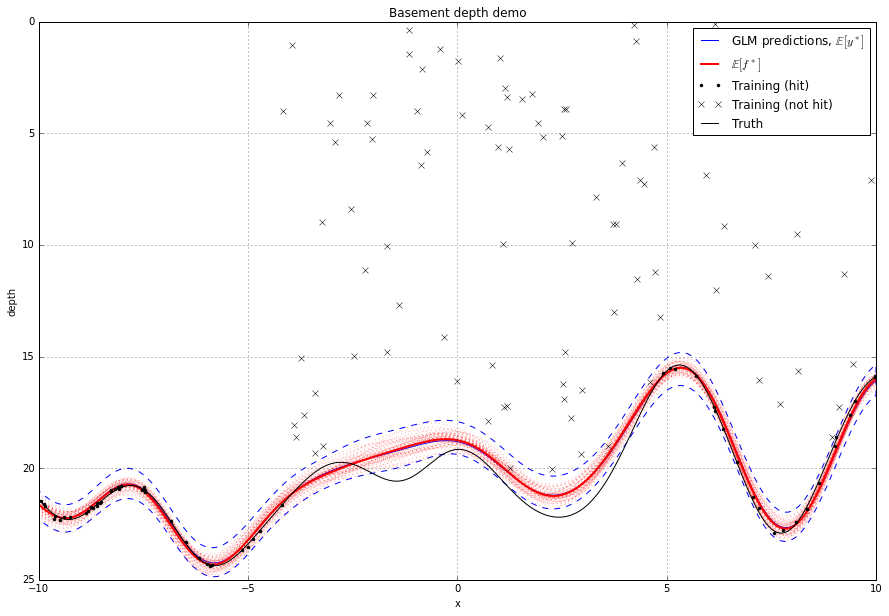

In [59]:
Xpl_t = Xtrain.flatten()
Xpl_s = Xtest.flatten()

# Regressor observations
pl.figure(figsize=(fig_width, fig_height))
pl.plot(Xpl_s, Ey, 'b-', label='GLM predictions, $\mathbb{E}[y^*]$')
pl.fill_between(Xpl_s, y95n, y95x, facecolor='none', edgecolor='b', label=None,
                linestyle='--')

# Regressor latent function
pl.plot(Xpl_s, Ef, 'r-', linewidth=2, label='$\mathbb{E}[f^*]$')
pl.plot(Xpl_s, np.array(fsamples).T, 'r:', alpha=0.3)
#pl.fill_between(Xpl_s, Ef - 2*Sf, Ef + 2*Sf, facecolor='none', edgecolor='r', label=None,
#                linestyle='--')

# Training/Truth
pl.plot(Xpl_t[hit], ytrain[hit], 'k.', label='Training (hit)')
pl.plot(Xpl_t[not_hit], ytrain[not_hit], 'kx', label='Training (not hit)')
pl.plot(Xpl_s, gtest, 'k-', label='Truth')

pl.gca().invert_yaxis()
pl.legend()
pl.grid(True)
pl.title('Basement depth demo')
pl.ylabel('depth')
pl.xlabel('x')

pl.show()
